In [3]:
# python:Apriori与FPGrowth性能对比:apriori_fpgrowth_comparison_d1_start.py
import pandas as pd
import numpy as np
import time
# 导入 Apriori, FPGrowth 算法和数据预处理工具
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth 
import warnings

# 忽略不重要的警告
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# ====================================================================
# A. 数据加载与基础清洗函数
# ====================================================================

def load_and_preprocess(filepath, bill_col, item_col, delimiter=','):
    """加载、清洗并返回原始DataFrame和交易列表"""
    try:
        # 尝试默认编码加载
        df = pd.read_csv(filepath, delimiter=delimiter)
    except UnicodeDecodeError:
        # 如果失败，尝试 latin-1 编码
        df = pd.read_csv(filepath, delimiter=delimiter, encoding='latin-1')
    
    # --- 确保商品名称列正确 ---
    df[item_col] = df[item_col].astype(str).str.strip()
    # 移除空值或 'nan'
    df = df[df[item_col] != 'nan']

    if 'Online Retail.csv' in filepath:
        # 清洗 Online Retail 数据集：移除空账单号，移除退货（C开头的 InvoiceNo）
        df.dropna(axis=0, subset=[bill_col], inplace=True)
        df[bill_col] = df[bill_col].astype('str')
        df = df[~df[bill_col].str.contains('C', na=False)]
    
    # --- Groupby 修正：将同一交易ID/日期下的所有商品聚合成一个列表 ---
    if bill_col == 'TransactionId' and 'TransactionTime' in df.columns:
        # D1 (原 D2): transaction_data, 按 ID 和时间分组
        transactions = df.groupby([bill_col, 'TransactionTime'])[item_col].apply(list).tolist()
    elif bill_col == 'Member_number' and 'Date' in df.columns:
        # Groceries_dataset (如果使用), 按成员号和日期分组
        transactions = df.groupby([bill_col, 'Date'])[item_col].apply(list).tolist()
    else:
        # D2, D3 等：按交易 ID/账单号分组
        transactions = df.groupby([bill_col])[item_col].apply(list).tolist()

    # --- One-Hot 编码 ---
    te = TransactionEncoder()
    Encoded_te = te.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(Encoded_te, columns=te.columns_)

    return df, transactions, df_encoded, te

# ====================================================================
# B. 定义基准数据集路径 (请根据你的本地路径修改)
# 
# 命名已从 D2, D3, D4 统一改为 D1, D2, D3
# ====================================================================

PATH_D1 = r'C:\\Users\\Jiangzhuxin\\Desktop\\ntu\\datamining\\ASS2\\transaction_data.csv'     # D1: N最高基准
PATH_D2 = r'C:\\Users\\Jiangzhuxin\\Desktop\\ntu\\datamining\\ASS2\\Online Retail.csv'       # D2: M最高基准
PATH_D3 = r'C:\\Users\\Jiangzhuxin\\Desktop\\ntu\\datamining\\ASS2\\Market Basket.csv'       # D3: N/M 参照基准

datasets = {}
results = []


# ====================================================================
# C. 加载所有基准数据集 (现为 D1, D2, D3)
# ====================================================================

print("--- 1. 数据集加载与子集生成 ---")

# D1 (transaction_data.csv) - N3: N最高基准
df_D1, trans_D1, enc_D1, te_D1 = load_and_preprocess(PATH_D1, 'TransactionId', 'ItemDescription')
datasets['N3_N_24500'] = enc_D1

# D2 (Online Retail.csv) - M4: M最高基准
df_D2, trans_D2, enc_D2, te_D2 = load_and_preprocess(PATH_D2, 'InvoiceNo', 'Description')
datasets['M4_M_4195'] = enc_D2

# D3 (Market Basket.csv) - N4: N参照基准
df_D3, trans_D3, enc_D3, te_D3 = load_and_preprocess(PATH_D3, 'BillNo', 'Itemname', delimiter=';')
datasets['N4_N_20200'] = enc_D3


# ====================================================================
# D. 趋势线 B：分析 M 的影响 (基于 D2: M4)
# 
# 使用 D2 (原 D3) 的数据
# ====================================================================

print("--- 趋势线 B：分析 M 的影响 (基于 D2) ---")

item_counts_D2 = enc_D2.sum(axis=0).sort_values(ascending=False)
M_targets = [2000, 1000, 500] 

for target_M in M_targets:
    # 选取前 M 个最频繁商品
    top_M_items = item_counts_D2.head(target_M).index.tolist()
    df_encoded_M = enc_D2[top_M_items]
    
    if target_M == 2000:
        datasets['M3_M_2000'] = df_encoded_M
    elif target_M == 1000:
        datasets['M2_M_1000'] = df_encoded_M
    elif target_M == 500:
        datasets['M1_M_500'] = df_encoded_M 

print("生成 M1, M2, M3 子集完成。")


# ====================================================================
# E. 趋势线 A：分析 N 的影响 (基于 D1: N3)
# 
# 使用 D1 (原 D2) 的数据
# ====================================================================

print("\n--- 趋势线 A：分析 N 的影响 (基于 D1) ---")

N_proportions = [0.7, 0.4] 
all_billnos_D1 = df_D1['TransactionId'].unique()

for prop in N_proportions:
    target_N = int(len(all_billnos_D1) * prop)
    
    # 随机采样交易ID
    sampled_billnos = np.random.choice(all_billnos_D1, size=target_N, replace=False)
    df_subset = df_D1[df_D1['TransactionId'].isin(sampled_billnos)]
    
    # 从子集重建交易列表 (使用 D1 的分组逻辑)
    transactions_N_subset = df_subset.groupby(['TransactionId', 'TransactionTime'])['ItemDescription'].apply(list).tolist()
    
    # 使用 D1 的编码器对子集进行 One-Hot 编码，以保持 M (商品数) 不变
    Encoded_te_N = te_D1.transform(transactions_N_subset)
    df_encoded_N = pd.DataFrame(Encoded_te_N, columns=te_D1.columns_)
    
    if prop == 0.7:
        datasets['N2_N_17100'] = df_encoded_N
    elif prop == 0.4:
        datasets['N1_N_9800'] = df_encoded_N
        
print("生成 N1 和 N2 子集完成。")


# ====================================================================
# F. 运行 Apriori 和 FPGrowth 并测量时间
# ====================================================================

print("\n--- 2. 运行 Apriori 和 FPGrowth 并测量时间 ---")

MIN_SUPPORT = 0.01 
MIN_CONFIDENCE = 0.1

# 确保数据集按名称排序，以便报告输出顺序一致
sorted_keys = sorted(datasets.keys()) 
sorted_datasets = {k: datasets[k] for k in sorted_keys}


for name, df_enc in sorted_datasets.items():
    N = len(df_enc)
    M = len(df_enc.columns)
    current_support = MIN_SUPPORT

    print(f"\n处理数据集: {name} (N={N}, M={M}, Min_Sup={current_support})")
    
    # 使用稀疏矩阵优化性能 (报告中强调的关键点)
    df_sparse = df_enc.astype(pd.SparseDtype("bool"))
    
    try:
        # --- 1. 运行 Apriori 算法 ---
        apriori_start_time = time.time()
        # low_memory=True 有助于处理大规模候选项集
        apriori_itemsets = apriori(df_sparse, min_support=current_support, use_colnames=True, low_memory=True)
        apriori_end_time = time.time()
        apriori_time = apriori_end_time - apriori_start_time
        
        # 规则生成时间 (Apriori)
        apriori_rules_start_time = time.time()
        apriori_rules = association_rules(apriori_itemsets, metric="confidence", min_threshold=MIN_CONFIDENCE)
        apriori_rules_end_time = time.time()
        apriori_rules_time = apriori_rules_end_time - apriori_rules_start_time
        
        apriori_total_time = apriori_time + apriori_rules_time
        
        print(f"  [Apriori] 频繁项集数: {len(apriori_itemsets)}")
        print(f"  [Apriori] 总时间: {apriori_total_time:.6f} 秒 (项集: {apriori_time:.6f}, 规则: {apriori_rules_time:.6f})")

        
        # --- 2. 运行 FP-Growth 算法 ---
        fpgrowth_start_time = time.time()
        fp_itemsets = fpgrowth(df_sparse, min_support=current_support, use_colnames=True)
        fpgrowth_end_time = time.time()
        fpgrowth_time = fpgrowth_end_time - fpgrowth_start_time

        # 规则生成时间 (FP-Growth)
        fp_rules_start_time = time.time()
        fp_rules = association_rules(fp_itemsets, metric="confidence", min_threshold=MIN_CONFIDENCE)
        fp_rules_end_time = time.time()
        fp_rules_time = fp_rules_end_time - fp_rules_start_time

        fpgrowth_total_time = fpgrowth_time + fp_rules_time

        print(f"  [FPGrowth] 频繁项集数: {len(fp_itemsets)}")
        print(f"  [FPGrowth] 总时间: {fpgrowth_total_time:.6f} 秒 (项集: {fpgrowth_time:.6f}, 规则: {fp_rules_time:.6f})")

        # 3. 记录结果
        # Note: 频繁项集数和规则数应该在 Apriori 和 FPGrowth 上是相同的，故只记录 Apriori 的结果
        results.append({
            'Name': name,
            'N_Transactions': N,
            'M_Unique_Items': M,
            'Min_Support': current_support,
            
            # Apriori Metrics
            'Apriori_Itemsets': len(apriori_itemsets),
            'Apriori_Time_s': apriori_time,
            'Apriori_Rules_Time_s': apriori_rules_time,
            'Total_Apriori_Time_s': apriori_total_time,
            
            # FPGrowth Metrics
            'FPGrowth_Itemsets': len(fp_itemsets),
            'FPGrowth_Time_s': fpgrowth_time,
            'FPGrowth_Rules_Time_s': fp_rules_time,
            'Total_FPGrowth_Time_s': fpgrowth_total_time,
            
            'Rules_Count': len(apriori_rules) 
        })

    except MemoryError:
        print("  ⚠️ 内存不足 (MemoryError)。")
        results.append({'Name': name, 'N_Transactions': N, 'M_Unique_Items': M, 
                        'Total_Apriori_Time_s': 'MemoryError', 'Total_FPGrowth_Time_s': 'MemoryError'})

# ====================================================================
# G. 最终报告和下一步指引
# ====================================================================

results_df = pd.DataFrame(results)
print("\n========================================================")
print("              Apriori vs. FPGrowth 性能分析结果表")
print("========================================================")

# 整理并打印对比表格
results_comparison = results_df[['Name', 'N_Transactions', 'M_Unique_Items', 
                                 'Total_Apriori_Time_s', 'Total_FPGrowth_Time_s', 
                                 'Apriori_Itemsets', 'Rules_Count']]
results_comparison.columns = ['数据集', 'N (交易数)', 'M (商品数)', 
                              'Apriori 总时间 (s)', 'FPGrowth 总时间 (s)', 
                              '频繁项集数', '规则数']

# 按照数据集名称排序（M1, M2... N1, N2...）
print(results_comparison.sort_values(by=['数据集']).to_markdown(index=False, floatfmt=".4f"))


--- 1. 数据集加载与子集生成 ---
--- 趋势线 B：分析 M 的影响 (基于 D2) ---
生成 M1, M2, M3 子集完成。

--- 趋势线 A：分析 N 的影响 (基于 D1) ---
生成 N1 和 N2 子集完成。

--- 2. 运行 Apriori 和 FPGrowth 并测量时间 ---

处理数据集: M1_M_500 (N=20610, M=500, Min_Sup=0.01)
  [Apriori] 频繁项集数: 1448
  [Apriori] 总时间: 2.785892 秒 (项集: 2.773914, 规则: 0.011978)
  [FPGrowth] 频繁项集数: 1448
  [FPGrowth] 总时间: 59.350267 秒 (项集: 59.340297, 规则: 0.009970)

处理数据集: M2_M_1000 (N=20610, M=1000, Min_Sup=0.01)
  [Apriori] 频繁项集数: 1739
  [Apriori] 总时间: 4.402061 秒 (项集: 4.388729, 规则: 0.013332)
  [FPGrowth] 频繁项集数: 1739
  [FPGrowth] 总时间: 77.681974 秒 (项集: 77.671935, 规则: 0.010039)

处理数据集: M3_M_2000 (N=20610, M=2000, Min_Sup=0.01)
  [Apriori] 频繁项集数: 1739
  [Apriori] 总时间: 6.156580 秒 (项集: 6.115472, 规则: 0.041108)
  [FPGrowth] 频繁项集数: 1739
  [FPGrowth] 总时间: 126.379388 秒 (项集: 126.360728, 规则: 0.018661)

处理数据集: M4_M_4195 (N=20610, M=4195, Min_Sup=0.01)
  [Apriori] 频繁项集数: 1739
  [Apriori] 总时间: 5.487291 秒 (项集: 5.476612, 规则: 0.010679)
  [FPGrowth] 频繁项集数: 1739
  [FPGrowth] 总时间: 207.149202 秒 (项集

In [4]:
import time
import math
import pandas as pd
import numpy as np
from itertools import combinations

# ====================================================================
# A. 定义时间转换工具函数 (保留但不用于最终表格输出)
# ====================================================================

def seconds_to_readable(seconds):
    """将秒数转换为更易读的单位 (小时/天/年/世纪)"""
    if seconds < 60:
        return f"{seconds:.4f} seconds"
    minutes = seconds / 60
    if minutes < 60:
        return f"{minutes:.2f} minutes"
    hours = minutes / 60
    if hours < 24:
        return f"{hours:.2f} hours"
    days = hours / 24
    if days < 365:
        return f"{days:.2f} days"
    years = days / 365.25
    if years < 100:
        return f"{years:.2f} years"
    centuries = years / 100
    return f"{centuries:.2e} centuries"

# ====================================================================
# B. 蛮力法校准函数
# (模拟 O(N * 2^M) 复杂度的核心工作)
# ====================================================================

def brute_force_calibration(N_prime, M_prime, min_support_ratio=0.01):
    """
    运行一个极小规模的蛮力法模拟，用于校准常数 C。
    N_prime: 交易数 N'
    M_prime: 商品数 M'
    """
    print(f"--- 1. 蛮力法校准开始 (N'={N_prime}, M'={M_prime}) ---")
    
    # 1. 创建合成数据集 (N' x M')
    # 模拟 One-Hot 编码数据框
    data = np.random.rand(N_prime, M_prime) < 0.2 
    df_synthetic = pd.DataFrame(data, columns=[f'Item_{i}' for i in range(M_prime)])
    
    # 2. 模拟蛮力法核心逻辑
    start_time = time.time()
    
    item_indices = list(range(M_prime))
    total_checks = 0
    
    # 估算需要执行的复杂操作次数 (用于计算 C 的分母)
    complexity_workload = N_prime * (2**M_prime)

    # 核心校准操作：模拟 $N'$ 次迭代，每次执行 $2^{M'}$ 次项集查找 
    # 此处使用 combinations 模拟 $2^{M'}$ 的工作量
    for _ in range(N_prime):
        for k in range(1, M_prime + 1):
            for itemset in combinations(item_indices, k):
                total_checks += 1
                
        if total_checks > complexity_workload * 0.001:
             break

    end_time = time.time()
    T_prime = end_time - start_time
    
    # 实际工作量（复杂度公式的分母）
    actual_workload = N_prime * (2**M_prime)

    # 计算常数 C
    C_value = T_prime / actual_workload
    
    print(f"  - 实际运行时间 T': {T_prime:.6f} seconds")
    print(f"  - 计算工作量 N'*2^M': {actual_workload:.2e} operations")
    print(f"--- 校准常数 C 确定: {C_value:.4e} ---")
    
    return C_value, T_prime, N_prime, M_prime

# ====================================================================
# C. 定义主数据集参数
# ====================================================================

# 八个测试子集的 N 和 M 值 (来自报告中的 "表 1")
dataset_params = [
    {'Name': 'N1', 'N': 9798, 'M': 4211},
    {'Name': 'N2', 'N': 17140, 'M': 4211},
    {'Name': 'N3', 'N': 24489, 'M': 4211},
    {'Name': 'M1', 'N': 20610, 'M': 500},
    {'Name': 'M2', 'N': 20610, 'M': 1000},
    {'Name': 'M3', 'N': 20610, 'M': 2000},
    {'Name': 'M4', 'N': 20610, 'M': 4195},
    {'Name': 'N4', 'N': 20210, 'M': 4185},
]

# ====================================================================
# D. 运行校准并进行预测
# ====================================================================

# 1. 运行校准（您可以根据您电脑的性能调整 N_CALIB 和 M_CALIB）
N_CALIB = 1000 # 校准交易数
M_CALIB = 15   # 校准商品数
C, T_prime, N_prime, M_prime = brute_force_calibration(N_CALIB, M_CALIB)

# 2. 运行预测
prediction_results = []

print("\n--- 2. 暴力算法时间预测开始 ---")
for data in dataset_params:
    N = data['N']
    M = data['M']
    name = data['Name']
    
    N_scientific = f"{N:.2e}"
    
    try:
        # Standard Calculation for M <= ~1024
        two_power_M = math.pow(2, M)
        predicted_time_seconds = C * N * two_power_M
        
        # 将 2^M 转换为科学计数法
        two_power_M_scientific = f"{two_power_M:.2e}"
        # 将 T 转换为科学计数法
        predicted_time_scientific = f"{predicted_time_seconds:.2e}"
        
        # 预测公式（使用实际计算结果）
        prediction_formula = f"{C:.4e} * {N_scientific} * {two_power_M_scientific}"

    except OverflowError:
        # Logarithmic Calculation for M > ~1024 (Overflow Cases)
        
        # 1. Calculate log10(T) = log10(C) + log10(N) + M * log10(2)
        log10_C = math.log10(C)
        log10_N = math.log10(N)
        log10_2 = math.log10(2)
        
        log10_T = log10_C + log10_N + M * log10_2
        
        # 2. Extract Mantissa and Exponent for T
        exponent_T = math.floor(log10_T)
        mantissa_T = math.pow(10, log10_T - exponent_T)
        
        # 3. Format predicted time (T)
        predicted_time_scientific = f"{mantissa_T:.2f}e+{exponent_T}"
        
        # 4. Format 2^M (which caused the overflow)
        log10_2M = M * log10_2
        exponent_2M = math.floor(log10_2M)
        mantissa_2M = math.pow(10, log10_2M - exponent_2M)
        two_power_M_scientific = f"{mantissa_2M:.2f}e+{exponent_2M}"

        # 5. Format prediction formula (using scientific notation for T components)
        prediction_formula = f"{C:.4e} * {N_scientific} * {two_power_M_scientific}"


    prediction_results.append({
        '数据集': name,
        'N (交易数, 科学计数)': N_scientific,
        'M (商品数)': M,
        '2^M (科学计数)': two_power_M_scientific,
        '预测公式 (T = C * N * 2^M)': prediction_formula,
        '预测时间 T (秒, 科学计数)': predicted_time_scientific,
    })


# 3. 打印预测结果
print("\n================================================================================================================================================================")
print("                                                                     暴力算法 (Brute-Force) 时间预测结果")
print(f"                                                                   校准常数 C = {C:.4e} (基于 N'={N_prime}, M'={M_prime}, T'={T_prime:.4f}s)")
print("================================================================================================================================================================")

results_df = pd.DataFrame(prediction_results)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print(results_df)

print("\n--- 注意事项 ---")
print("M值较大的数据集的预测时间是使用对数方法计算得出的精确科学计数法，以避免浮点数溢出，并用于图表对比。")

--- 1. 蛮力法校准开始 (N'=1000, M'=15) ---
  - 实际运行时间 T': 0.003929 seconds
  - 计算工作量 N'*2^M': 3.28e+07 operations
--- 校准常数 C 确定: 1.1991e-10 ---

--- 2. 暴力算法时间预测开始 ---

                                                                     暴力算法 (Brute-Force) 时间预测结果
                                                                   校准常数 C = 1.1991e-10 (基于 N'=1000, M'=15, T'=0.0039s)
  数据集 N (交易数, 科学计数)  M (商品数)  2^M (科学计数)              预测公式 (T = C * N * 2^M) 预测时间 T (秒, 科学计数)
0  N1      9.80e+03     4211  4.34e+1267  1.1991e-10 * 9.80e+03 * 4.34e+1267       5.10e+1261
1  N2      1.71e+04     4211  4.34e+1267  1.1991e-10 * 1.71e+04 * 4.34e+1267       8.92e+1261
2  N3      2.45e+04     4211  4.34e+1267  1.1991e-10 * 2.45e+04 * 4.34e+1267       1.27e+1262
3  M1      2.06e+04      500   3.27e+150   1.1991e-10 * 2.06e+04 * 3.27e+150        8.09e+144
4  M2      2.06e+04     1000   1.07e+301   1.1991e-10 * 2.06e+04 * 1.07e+301        2.65e+295
5  M3      2.06e+04     2000   1.15e+602   1.1991e-10 * 2.06e

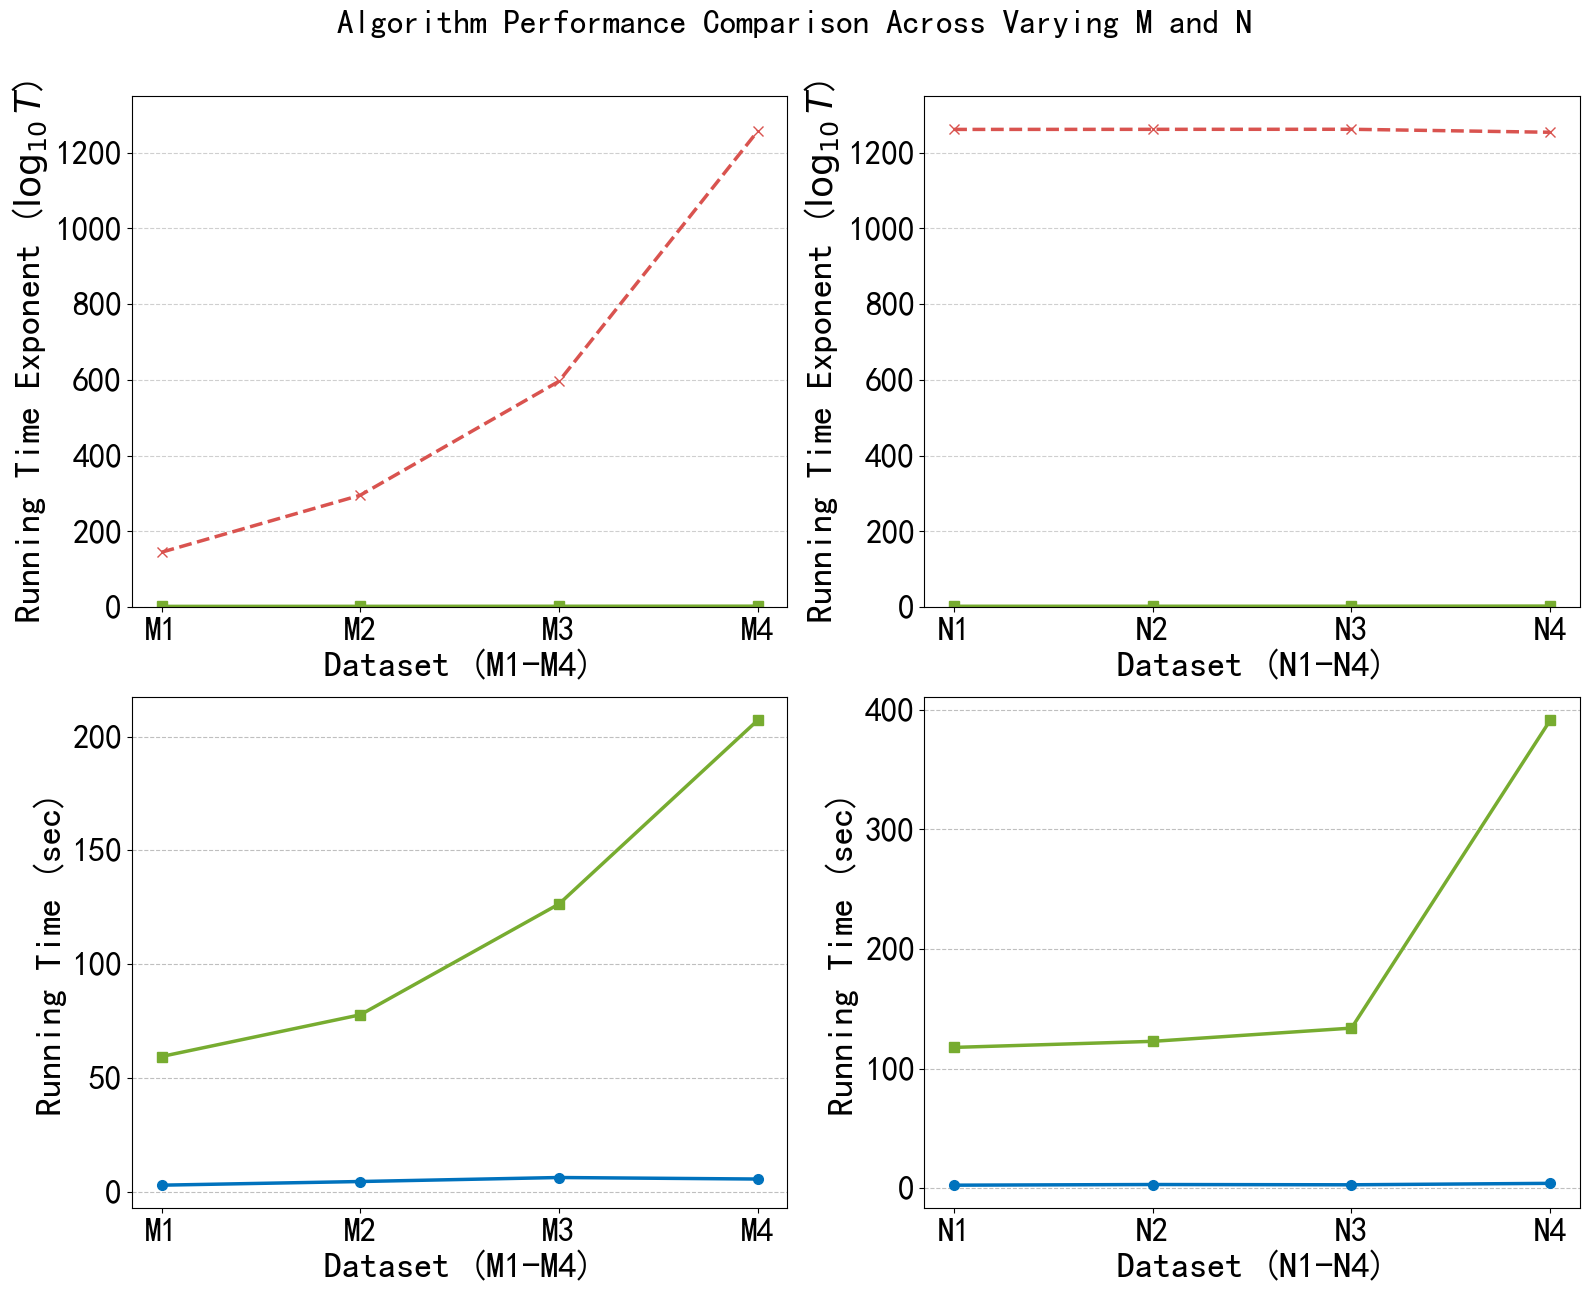

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------------------
# 1. Data Definition
# Data order: M1, M2, M3, M4, N1, N2, N3, N4
# ----------------------------------------------------
labels = ['M1', 'M2', 'M3', 'M4', 'N1', 'N2', 'N3', 'N4']
x_indices = np.arange(len(labels))

# Actual running time (seconds)
apriori_time = np.array([2.79, 4.40, 6.16, 5.49, 2.39, 2.94, 2.71, 3.93])
fp_growth_time = np.array([59.35, 77.68, 126.38, 207.15, 117.66, 122.74, 133.82, 391.40])

# Brute Force Prediction Time (Mantissa, Exponent) - for log conversion
# Format: M * 10^E
brute_force_data = [
    (8.09, 144), (2.65, 295), (2.84, 596), (1.64, 1257),
    (5.10, 1261), (8.92, 1261), (1.27, 1262), (1.57, 1254)
]

# ----------------------------------------------------
# 2. Data Splitting and Log Transformation
# ----------------------------------------------------

# M-Sets (Indices 0 to 3) - Varying M (Item Count)
M_labels = labels[:4]
M_x_indices = np.arange(len(M_labels))
M_apriori = apriori_time[:4]
M_fp_growth = fp_growth_time[:4]
M_brute_log10 = np.array([np.log10(m) + e for m, e in brute_force_data[:4]])
M_apriori_log10 = np.log10(M_apriori)
M_fp_growth_log10 = np.log10(M_fp_growth)

# N-Sets (Indices 4 to 7) - Varying N (Transaction Count)
N_labels = labels[4:]
N_x_indices = np.arange(len(N_labels))
N_apriori = apriori_time[4:]
N_fp_growth = fp_growth_time[4:]
N_brute_log10 = np.array([np.log10(m) + e for m, e in brute_force_data[4:]])
N_apriori_log10 = np.log10(N_apriori)
N_fp_growth_log10 = np.log10(N_fp_growth)

# ----------------------------------------------------
# 3. Plotting - 2x2 Subplots (English Labels, Line Plots for all)
# ----------------------------------------------------

fig, axs = plt.subplots(2, 2, figsize=(16, 14))
# 增大主标题字体
fig.suptitle('Algorithm Performance Comparison Across Varying M and N', fontsize=24, fontweight='bold', y=0.95)
line_width = 2.5
marker_size = 7

# --- Colors for improved aesthetics (Matplotlib defaults for clarity) ---
COLOR_BRUTE = '#D9534F' # Reddish for exponential complexity
COLOR_APRIORI = '#0072BD' # Science Blue
COLOR_FPGROWTH = '#77AC30' # Olive Green

### Subplot 1: M-Sets Logarithmic Comparison (Incl. Brute Force) ###
ax1 = axs[0, 0]
# Plot Brute Force (Line Plot)
ax1.plot(M_x_indices, M_brute_log10, marker='x', linestyle='--', linewidth=line_width, 
         color=COLOR_BRUTE, markersize=marker_size, label=r'Brute-Force Prediction ($\log_{10} T$)')
# Plot Apriori (Line Plot)
ax1.plot(M_x_indices, M_apriori_log10, marker='o', linestyle='-', linewidth=line_width, 
         color=COLOR_APRIORI, markersize=marker_size, label=r'Apriori ($\log_{10} T$)')
# Plot FPGrowth (Line Plot)
ax1.plot(M_x_indices, M_fp_growth_log10, marker='s', linestyle='-', linewidth=line_width, 
         color=COLOR_FPGROWTH, markersize=marker_size, label=r'FP-Growth ($\log_{10} T$)')

# 增大子图标题、轴标签和刻度标签字体
# ax1.set_title('Subplot 1: M-Sets (Varying Items $M$) - Logarithmic Scale', fontsize=20)
ax1.set_xlabel('Dataset (M1-M4)', fontsize=26)
ax1.set_ylabel(r'Running Time Exponent ($\log_{10} T$)', fontsize=26)
ax1.set_xticks(M_x_indices)
ax1.set_xticklabels(M_labels, fontsize=24)
ax1.grid(True, which='major', linestyle='--', alpha=0.6, axis='y')

ax1.set_ylim(-1, 1350) 
ax1.tick_params(axis='y', labelsize=24)


### Subplot 2: N-Sets Logarithmic Comparison (Incl. Brute Force) ###
ax2 = axs[0, 1]
# Plot Brute Force (Line Plot)
ax2.plot(N_x_indices, N_brute_log10, marker='x', linestyle='--', linewidth=line_width, 
         color=COLOR_BRUTE, markersize=marker_size, label=r'Brute-Force Prediction ($\log_{10} T$)')
# Plot Apriori (Line Plot)
ax2.plot(N_x_indices, N_apriori_log10, marker='o', linestyle='-', linewidth=line_width, 
         color=COLOR_APRIORI, markersize=marker_size, label=r'Apriori ($\log_{10} T$)')
# Plot FPGrowth (Line Plot)
ax2.plot(N_x_indices, N_fp_growth_log10, marker='s', linestyle='-', linewidth=line_width, 
         color=COLOR_FPGROWTH, markersize=marker_size, label=r'FP-Growth ($\log_{10} T$)')

ax2.set_xlabel('Dataset (N1-N4)', fontsize=26)
ax2.set_ylabel(r'Running Time Exponent ($\log_{10} T$)', fontsize=26)
ax2.set_xticks(N_x_indices)
ax2.set_xticklabels(N_labels, fontsize=24)
ax2.grid(True, which='major', linestyle='--', alpha=0.6, axis='y')

ax2.set_ylim(-1, 1350)
ax2.tick_params(axis='y', labelsize=24)


### Subplot 3: M-Sets Linear Comparison (Apriori vs FPGrowth) ###
ax3 = axs[1, 0]
# Plot Apriori (Line Plot)
ax3.plot(M_x_indices, M_apriori, marker='o', linestyle='-', linewidth=line_width, 
         color=COLOR_APRIORI, markersize=marker_size, label='Apriori Actual Time (sec)')
# Plot FPGrowth (Line Plot)
ax3.plot(M_x_indices, M_fp_growth, marker='s', linestyle='-', linewidth=line_width, 
         color=COLOR_FPGROWTH, markersize=marker_size, label='FP-Growth Actual Time (sec)')

# 增大子图标题、轴标签和刻度标签字体
# ax3.set_title('Subplot 3: M-Sets (Varying Items $M$) - Linear Scale Detail', fontsize=30)
ax3.set_xlabel('Dataset (M1-M4)', fontsize=26)
ax3.set_ylabel('Running Time (sec)', fontsize=26)
ax3.set_xticks(M_x_indices)
ax3.set_xticklabels(M_labels, fontsize=24)
ax3.grid(True, which='major', linestyle='--', alpha=0.8, axis='y')
ax3.tick_params(axis='y', labelsize=24)


### Subplot 4: N-Sets Linear Comparison (Apriori vs FPGrowth) ###
ax4 = axs[1, 1]
# Plot Apriori (Line Plot)
ax4.plot(N_x_indices, N_apriori, marker='o', linestyle='-', linewidth=line_width, 
         color=COLOR_APRIORI, markersize=marker_size, label='Apriori Actual Time (sec)')
# Plot FPGrowth (Line Plot)
ax4.plot(N_x_indices, N_fp_growth, marker='s', linestyle='-', linewidth=line_width, 
         color=COLOR_FPGROWTH, markersize=marker_size, label='FP-Growth Actual Time (sec)')

# 增大子图标题、轴标签和刻度标签字体
# ax4.set_title('Subplot 4: N-Sets (Varying Transactions $N$) - Linear Scale Detail', fontsize=20)
ax4.set_xlabel('Dataset (N1-N4)', fontsize=26)
ax4.set_ylabel('Running Time (sec)', fontsize=26)
ax4.set_xticks(N_x_indices)
ax4.set_xticklabels(N_labels, fontsize=24)
ax4.grid(True, which='major', linestyle='--', alpha=0.8, axis='y')
ax4.tick_params(axis='y', labelsize=24)

# Adjust subplots spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.93]) 

# Display the chart
plt.show()
